In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

## Set up, load data, and clean

add language for each text excerpts, filter out non-English excerpts.

In [2]:
data_dir = "/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/"
sdg_names = pd.read_csv(data_dir + "sdg_name_definition.csv")

text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
text_df = text_df.query("lang == 'en'")
text_df.reset_index(inplace=True,drop=True)

In [3]:
sdg_names.iloc[0]

sdg                                                     1
sdg_name                                       No Poverty
sdg_definition    End poverty in all its forms everywhere
Name: 0, dtype: object

In [4]:
text_df.shape

(26470, 7)

## Tokenization of documents using sklearn

In [5]:
corpus = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(corpus)
count_vector = count_vectorizer.transform(corpus).toarray() 
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
term_freq.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,8492
women,women,6017
development,development,5889
public,public,4819
social,social,4754
...,...,...
maasai,maasai,1
maartje,maartje,1
maanen,maanen,1
maaf,maaf,1


### looking at language models and feature for the task of document classification
 - split the data into train and test
 - construct text feature vectors using 
  - CountVectorizer, TfidfVectorizer
  - with unigram, bigram, and unigram and bigram combined
 - use Naive Bayes - multinomialNB implementation to assess the feature vectors' effectiveness
 - inspect the top informative features (tokens)

In [6]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.33, random_state=7)

### using count vectors as feature and use multinomialNB

features = bigrams (ngram_range = (2,2))

remove stop words (stop_words = "english")

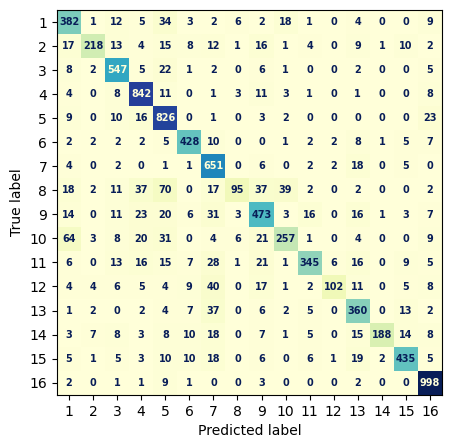

In [7]:
X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train) 
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)


 - understanding metrics in the context of multiple classes

In [8]:
# manually check precision for sdg 1 --> these numbers will be wrong because they are accurate if you don't choose to detect english at the beginning
tp = 389
fp = 113 #(summing vertically below 389)
fn = 96 #(summing horizentally to the right of 398)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) /(precision + recall)

In [9]:
print('precision for SDG 1: {:.4}'.format(precision))
print('recall for SDG 1: {:.4}'.format(recall))
print('f1 for SDG 1: {:.4}'.format(f1))

precision for SDG 1: 0.7749
recall for SDG 1: 0.8021
f1 for SDG 1: 0.7882


 - inspecting (and comparing) performance through classification_report
 - looking at row #1 for SDG 1, it should match with above numbers

In [10]:
print(metrics.classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           1     0.7035    0.7975    0.7476       479
           2     0.9008    0.6586    0.7609       331
           3     0.8326    0.9101    0.8696       601
           4     0.8557    0.9429    0.8972       893
           5     0.7613    0.9281    0.8365       890
           6     0.8717    0.8973    0.8843       477
           7     0.7466    0.9408    0.8325       692
           8     0.8261    0.2861    0.4251       332
           9     0.7449    0.7544    0.7496       627
          10     0.7788    0.6005    0.6781       428
          11     0.8801    0.7055    0.7832       489
          12     0.9027    0.4679    0.6163       218
          13     0.7392    0.8163    0.7759       441
          14     0.9741    0.6373    0.7705       295
          15     0.8717    0.8270    0.8488       526
          16     0.9089    0.9813    0.9437      1017

    accuracy                         0.8181      8736
   macro avg     0.8312   

 - inspect individual scores

In [11]:
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

accuracy = 0.8181
macro-averaged precision = 0.8312
micro-averaged precision = 0.8181
macro-averaged recall = 0.7595
micro-averaged recall = 0.8181


 - put it all together
 - unigram and bigram together

              precision    recall  f1-score   support

           1       0.74      0.79      0.76       479
           2       0.89      0.70      0.78       331
           3       0.89      0.93      0.91       601
           4       0.88      0.96      0.92       893
           5       0.79      0.93      0.86       890
           6       0.89      0.90      0.89       477
           7       0.73      0.96      0.83       692
           8       0.89      0.25      0.39       332
           9       0.75      0.83      0.79       627
          10       0.77      0.59      0.67       428
          11       0.88      0.74      0.81       489
          12       0.91      0.36      0.52       218
          13       0.81      0.79      0.80       441
          14       0.98      0.64      0.78       295
          15       0.88      0.89      0.88       526
          16       0.87      0.99      0.93      1017

    accuracy                           0.83      8736
   macro avg       0.85   

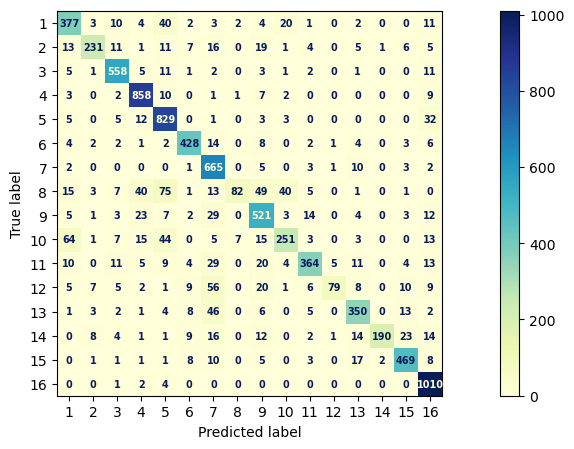

In [14]:
X_train_count_vectorizer = CountVectorizer(ngram_range=(1,2), stop_words = "english", min_df=2)
X_train_count_vectorizer.fit(X_train)  
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"])
print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))


from the above, it looks like using both unigram and bigram performed better than using only bigram

### tfidf vector with multinomialNB

              precision    recall  f1-score   support

           1       0.87      0.50      0.64       479
           2       0.98      0.12      0.22       331
           3       0.91      0.85      0.88       601
           4       0.76      0.96      0.85       893
           5       0.43      0.94      0.58       890
           6       0.92      0.65      0.76       477
           7       0.54      0.98      0.70       692
           8       1.00      0.01      0.01       332
           9       0.84      0.62      0.71       627
          10       0.91      0.16      0.27       428
          11       0.96      0.39      0.56       489
          12       0.91      0.05      0.09       218
          13       0.94      0.57      0.71       441
          14       1.00      0.14      0.25       295
          15       0.92      0.70      0.79       526
          16       0.59      0.99      0.74      1017

    accuracy                           0.66      8736
   macro avg       0.84   

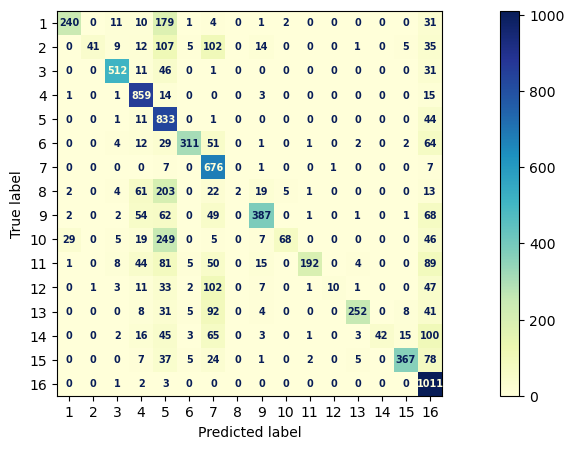

In [15]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words = "english")
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

tfidf_multinomialNB_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomialNB_clf.predict(X_test_tfidf_vector)

print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax,cmap=mpl.colormaps["YlGnBu"])


using multinomialNB on tfidf vectors seems to perform worse

 - let's run one more using tfidf but with bigram only

              precision    recall  f1-score   support

           1       0.86      0.51      0.64       479
           2       1.00      0.09      0.17       331
           3       0.89      0.80      0.84       601
           4       0.72      0.94      0.82       893
           5       0.42      0.94      0.58       890
           6       0.95      0.58      0.72       477
           7       0.69      0.92      0.79       692
           8       1.00      0.01      0.01       332
           9       0.87      0.47      0.61       627
          10       0.92      0.19      0.31       428
          11       0.97      0.29      0.44       489
          12       1.00      0.02      0.04       218
          13       0.91      0.57      0.70       441
          14       1.00      0.02      0.05       295
          15       0.95      0.55      0.70       526
          16       0.43      0.99      0.60      1017

    accuracy                           0.62      8736
   macro avg       0.85   

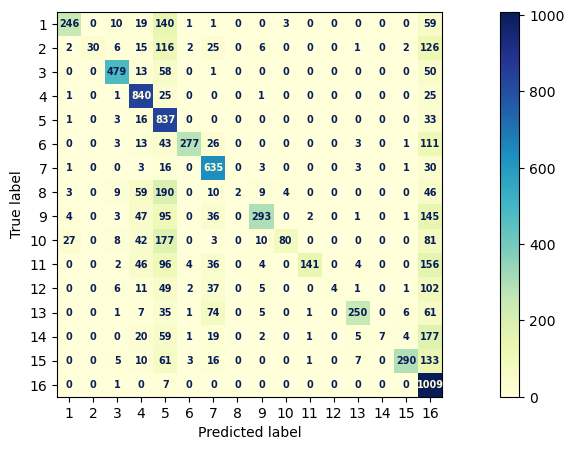

In [16]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train) 
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test) 

tfidf_multinomialNB_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)
y_pred = tfidf_multinomialNB_clf.predict(X_test_tfidf_vector)

print(metrics.classification_report(y_test,y_pred))
print("accuracy = {:.4}".format(metrics.accuracy_score(y_test, y_pred)))
print("macro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'macro')))
print("macro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'macro')))
print("weighted-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'weighted')))
print("weighted-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'weighted')))
print("micro-averaged precision = {:.4}".format(metrics.precision_score(y_test, y_pred, average = 'micro')))
print("micro-averaged recall = {:.4}".format(metrics.recall_score(y_test, y_pred, average = 'micro')))

fig, ax = plt.subplots(figsize=(15, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax,cmap=mpl.colormaps["YlGnBu"])


multinomialNB on ifidf vector performed the same on unigram + bigram, or bigram only
 - 
 Re-run the above cells to compare performances with different parameters
  - multinomialNB on count vectors of bigram only
  - multinomialNB on count vectors of unigram and bigram
  - multinomialNB on tfidf vectors of unigram and bigram
  - multinomialNB on tfidf vectors of bigram only

any conclusion is specific to this corpus, not to be generalized

### looking at the most informative features

In [17]:
X_train_tfidf_vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_tfidf_vectorizer.fit(X_train)
labels = X_train_tfidf_vectorizer.get_feature_names_out()

X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)
X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

tfidf_multinomialNB_clf = MultinomialNB().fit(X_train_tfidf_vector, y_train)

* feature_log_prob_ is ndarray of shape (n_classes, n_features), producing the empirical log probability of features given a class, P(x_i | y)
* tfidf_multinomialNB_clf.classes_ produces the class labels known to the classifier, tfidf_multinomialNB_clf.classes_[0] is 1, meaning SDG 1.
so we know the arrangement of the results in the order of sdg_num. 
* tfidf_multinomialNB_clf.feature_log_prob_[0] gives the empirical probabilities (log) of each feature given class SDG 1. 

In [18]:
tfidf_multinomialNB_clf.classes_[0:16]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [19]:
tfidf_multinomialNB_clf.feature_log_prob_.shape

(16, 631341)

In [20]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    for labelid in classlabel:
        feature_names = vectorizer.get_feature_names_out()
        top_n = sorted(zip(classifier.feature_log_prob_[labelid], feature_names), reverse=True)[:n]
        for coef, feat in top_n:
            print("SDG {} : {:30}  {:.6}".format(labelid+1, feat, coef))
        print("")

In [21]:
most_informative_feature_for_class(X_train_tfidf_vectorizer,tfidf_multinomialNB_clf, [0, 13], n = 20)

SDG 1 : child poverty                   -10.564
SDG 1 : poverty line                    -10.8203
SDG 1 : extreme poverty                 -11.0717
SDG 1 : poverty rates                   -11.0828
SDG 1 : poverty rate                    -11.104
SDG 1 : poverty reduction               -11.1426
SDG 1 : social protection               -11.1464
SDG 1 : monetary poverty                -11.4858
SDG 1 : percentage points               -11.5488
SDG 1 : rural areas                     -11.6574
SDG 1 : multidimensional poverty        -11.675
SDG 1 : relative poverty                -11.7123
SDG 1 : poverty lines                   -11.7832
SDG 1 : low income                      -11.7893
SDG 1 : social assistance               -11.8274
SDG 1 : poor children                   -11.8318
SDG 1 : income poverty                  -11.8328
SDG 1 : poor households                 -11.8689
SDG 1 : world bank                      -11.8718
SDG 1 : income distribution             -11.8869

SDG 14 : fish stocks  

In [22]:
X_train_count_vectorizer = CountVectorizer(ngram_range=(2,2), stop_words = "english" )
X_train_count_vectorizer.fit(X_train)  
X_train_count_vector = X_train_count_vectorizer.transform(X_train) 
X_test_count_vector = X_train_count_vectorizer.transform(X_test) 

count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
most_informative_feature_for_class(X_train_count_vectorizer,count_multinomialNB_clf, [0, 13], n = 20)

SDG 1 : child poverty                   -8.24432
SDG 1 : poverty line                    -8.51172
SDG 1 : poverty rates                   -8.78731
SDG 1 : social protection               -8.82653
SDG 1 : poverty rate                    -8.85699
SDG 1 : extreme poverty                 -8.85699
SDG 1 : poverty reduction               -8.87783
SDG 1 : percentage points               -9.22701
SDG 1 : monetary poverty                -9.35416
SDG 1 : rural areas                     -9.37126
SDG 1 : et al                           -9.48046
SDG 1 : low income                      -9.49988
SDG 1 : world bank                      -9.58155
SDG 1 : economic growth                 -9.60306
SDG 1 : relative poverty                -9.6705
SDG 1 : multidimensional poverty        -9.6705
SDG 1 : income distribution             -9.71813
SDG 1 : social assistance               -9.76814
SDG 1 : poverty lines                   -9.79412
SDG 1 : income poverty                  -9.82078

SDG 14 : fish stocks 

In [23]:
most_informative_feature_for_class(X_train_count_vectorizer,count_multinomialNB_clf, [8], n = 20)
most_informative_feature_for_class(X_train_tfidf_vectorizer,tfidf_multinomialNB_clf, [8], n = 20)

SDG 9 : developing countries            -8.48915
SDG 9 : private sector                  -9.12126
SDG 9 : new technologies                -9.32486
SDG 9 : sustainable development         -9.4817
SDG 9 : science technology              -9.50075
SDG 9 : mobile broadband                -9.53997
SDG 9 : long term                       -9.71432
SDG 9 : economic growth                 -9.71432
SDG 9 : aid trade                       -9.73842
SDG 9 : public sector                   -9.78843
SDG 9 : cross border                    -9.78843
SDG 9 : rural areas                     -9.86847
SDG 9 : developed countries             -9.89664
SDG 9 : world bank                      -9.92563
SDG 9 : technology innovation           -9.92563
SDG 9 : public private                  -9.95548
SDG 9 : fixed broadband                 -9.98625
SDG 9 : infrastructure investment       -10.018
SDG 9 : innovation policy               -10.0508
SDG 9 : infrastructure development      -10.0847

SDG 9 : developing co

### observation on computation cost on toarray or not
 - when doing
    X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train)

    X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test)

 - vs. doing

    X_train_tfidf_vector = X_train_tfidf_vectorizer.transform(X_train).toaray()

    X_test_tfidf_vector = X_train_tfidf_vectorizer.transform(X_test).toarray()
    
 - adding .toarray() make the model fitting and prediction much slower
 - the former (without toarray()) is about 10 second, on (2, 2) tfidf
 - the later is about 5 minutes

In [24]:
def print_top_n_features(vectorizer, clf, class_labels, n=10):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names_out()
    for i, class_label in enumerate(class_labels):
        top_n = np.argsort(clf.feature_log_prob_[i])[::-1][:n]
        print("%s: %s" % (class_label,
              " || ".join(feature_names[j] for j in top_n)))

In [25]:
print_top_n_features(X_train_tfidf_vectorizer,tfidf_multinomialNB_clf,[0,1,2,3,4,5,6,7,8,9,10],n=20)

0: child poverty || poverty line || extreme poverty || poverty rates || poverty rate || poverty reduction || social protection || monetary poverty || percentage points || rural areas || multidimensional poverty || relative poverty || poverty lines || low income || social assistance || poor children || income poverty || poor households || world bank || income distribution
1: food security || food insecurity || developing countries || agricultural sector || price volatility || agro food || climate change || agricultural land || food prices || agricultural production || world bank || food production || agricultural products || viet nam || access food || et al || agricultural research || domestic market || small scale || world food
2: health care || mental health || primary care || health services || public health || et al || oecd countries || care services || life expectancy || health insurance || quality care || long term || ministry health || risk factors || health systems || health out

In [26]:
# try todense() and compare with toarray(), no speed gain observed
corpus = text_df.text
count_vectorizer = CountVectorizer()  # add stop_words = 'english' to remove stop words
count_vector_dense = count_vectorizer.fit_transform(corpus).todense() # produce a dense representation for mamory order, possible for performance gain, but have not observed much.

In [27]:
corpus = text_df.text
count_vectorizer = CountVectorizer()
count_vector_dense_2 = count_vectorizer.fit_transform(corpus).toarray()